In [33]:
import jax
import jax.numpy as jnp
import optax

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm as tqdm
import pandas as pd

In [34]:
def generate_gaussian_samples(mu, cov, n_samples, seed=0):

    d = mu.shape[0]
    key = jax.random.PRNGKey(seed)
    z = jax.random.normal(key, shape=(n_samples, d))

    L = jnp.linalg.cholesky(cov)
    samples = mu + z @ L.T
    
    return samples

In [35]:
def potential_grad(sample, mu, cov):

    precision = jnp.linalg.inv(cov)

    return (sample - mu) @ precision

In [36]:
def evolve_langevin(samples, mu, cov, eps=1e-2, n_evolution=100, seed=0):
    
    key = jax.random.PRNGKey(seed)
    evolved_samples = samples

    for i in range(n_evolution):
        key, subkey = jax.random.split(key)
        grad = potential_grad(evolved_samples, mu, cov)
        noise = jax.random.normal(subkey, shape=evolved_samples.shape)
        evolved_samples = evolved_samples - eps * grad + jnp.sqrt(2 * eps) * noise

    return evolved_samples

In [37]:
def compute_moments_disc(samples, evolved_samples):

    mu_1 = jnp.mean(samples, axis=0)
    mu_2 = jnp.mean(evolved_samples, axis=0)

    centered_1 = samples - mu_1
    centered_2 = evolved_samples - mu_2

    cov_1 = centered_1.T @ centered_1 / samples.shape[0]
    cov_2 = centered_2.T @ centered_2 / evolved_samples.shape[0]

    loss_mu = jnp.sum((mu_1 - mu_2) ** 2)
    loss_cov = jnp.sum((cov_1 - cov_2) ** 2)

    return loss_mu + loss_cov

In [38]:
def lm_loss(samples, mu, cov):

    evolved_samples = evolve_langevin(samples, mu, cov)

    return compute_moments_disc(samples, evolved_samples)

In [39]:
def lm_optimize(samples, n_epochs=1000, lr=1e-2, seed=10, eps=1e-2, plot_every=2):
    n, d = samples.shape

    key = jax.random.PRNGKey(seed)
    key_mu, key_A = jax.random.split(key)

    mu = jax.random.normal(key_mu, shape=(d,))
    A = jax.random.normal(key_A, shape=(d, d))

    params = {
        "mu": mu,
        "A": A
    }

    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)

    def loss_fn(params, samples):
        mu = params["mu"]
        A = params["A"]
        cov = A.T @ A
        return lm_loss(samples, mu, cov)

    for epoch in range(n_epochs):
        loss_val, grads = jax.value_and_grad(loss_fn)(params, samples)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)

        if epoch % plot_every == 0 or epoch == n_epochs - 1:
            print(f"epoch {epoch} | loss = {loss_val:.6f}")

    final_mu = params["mu"]
    final_cov = params["A"].T @ params["A"]

    return final_mu, final_cov

In [40]:
def lm_optimize_with_tracking(
    samples,
    true_mu,
    true_cov,
    n_epochs=1000,
    base_lr=1e-2,
    seed=10,
    eps=1e-2,
    plot_every=200,
    use_lr_schedule=True
):
    n, d = samples.shape

    key = jax.random.PRNGKey(seed)
    key_mu, key_A = jax.random.split(key)

    mu = jax.random.normal(key_mu, shape=(d,))
    A = jax.random.normal(key_A, shape=(d, d))

    params = {
        "mu": mu,
        "A": A
    }

    # Define learning rate schedule (optional)
    if use_lr_schedule:
        lr_schedule = optax.linear_schedule(
            init_value=1e-2,     # valore iniziale piccolo
            end_value=base_lr,   # valore finale target
            transition_steps=500 # numero di step per raggiungerlo
        )
        optimizer = optax.adam(learning_rate=lr_schedule)
    else:
        optimizer = optax.adam(learning_rate=base_lr)


    opt_state = optimizer.init(params)

    def loss_fn(params, samples):
        mu = params["mu"]
        A = params["A"]
        cov = A.T @ A
        return lm_loss(samples, mu, cov)

    history = {
        "loss": [],
        "mu_l2": [],
        "cov_fro": [],
    }

    for epoch in range(n_epochs):
        loss_val, grads = jax.value_and_grad(loss_fn)(params, samples)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)

        mu_val = params["mu"]
        A_val = params["A"]
        cov_val = A_val.T @ A_val

        history["loss"].append(loss_val)
        history["mu_l2"].append(jnp.linalg.norm(true_mu - mu_val))
        history["cov_fro"].append(jnp.linalg.norm(true_cov - cov_val, ord='fro'))

        if epoch % plot_every == 0 or epoch == n_epochs - 1:
            print(f"epoch {epoch} | loss = {loss_val:.6f}")

    final_mu = params["mu"]
    final_cov = params["A"].T @ params["A"]

    return final_mu, final_cov, history


In [41]:
mu = jnp.array([0.0])

cov = jnp.array([
[1.0]
])

In [42]:
samples = generate_gaussian_samples(mu, cov, n_samples=2000, seed=0)

final_mu, final_cov, history = lm_optimize_with_tracking(samples, mu, cov, n_epochs=300, base_lr=0.1, seed = 0)

epoch 0 | loss = 2.241789
epoch 200 | loss = 0.000000
epoch 299 | loss = 0.000000


In [43]:
jnp.set_printoptions(precision=4, suppress=True)

print(jnp.round(mu, 4), "\n\n", jnp.round(final_mu, 4), jnp.linalg.norm(mu - final_mu), "\n\n\n")
print(jnp.round(cov, 4), "\n\n", jnp.round(final_cov, 4), jnp.linalg.norm(cov - final_cov), "\n\n\n")

[0.] 

 [-0.0535] 0.053545866 



[[1.]] 

 [[0.9813]] 0.018708587 





In [44]:
history_np = {k: np.array(v) for k, v in history.items()}

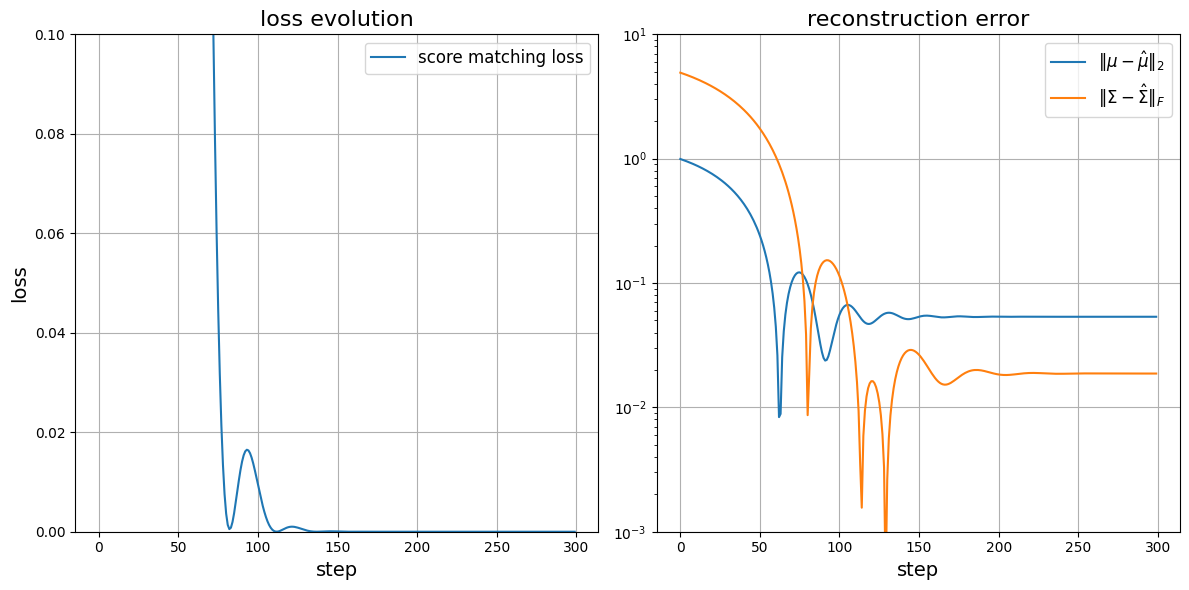

In [45]:
ymin_recon = 0
ymax_recon = 0.1
plt.figure(figsize=(12, 6))

# Primo plot: loss
plt.subplot(1, 2, 1)
plt.plot(history_np["loss"], label="score matching loss")
plt.ylim(ymin_recon, ymax_recon)
plt.xlabel("step", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.title("loss evolution", fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)

# Secondo plot: reconstruction error
ymin_recon = 1e-3
ymax_recon = 10.0
plt.subplot(1, 2, 2)
plt.plot(history_np["mu_l2"], label=r"$\| \mu - \hat{\mu} \|_2$")
plt.plot(history_np["cov_fro"], label=r"$\| \Sigma - \hat{\Sigma} \|_F$")
plt.ylim(ymin_recon, ymax_recon)
plt.yscale("log")
plt.xlabel("step", fontsize=14)
plt.title("reconstruction error", fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)

# Migliora layout e mostra
plt.tight_layout()
plt.show()

In [46]:
history_np["mu_l2"]

array([0.994 , 0.9838, 0.9735, 0.9629, 0.9522, 0.9413, 0.9302, 0.9189,
       0.9074, 0.8957, 0.8838, 0.8718, 0.8595, 0.8471, 0.8344, 0.8216,
       0.8085, 0.7952, 0.7818, 0.7681, 0.7542, 0.7401, 0.7258, 0.7113,
       0.6966, 0.6817, 0.6665, 0.6511, 0.6355, 0.6197, 0.6037, 0.5874,
       0.571 , 0.5543, 0.5374, 0.5203, 0.5029, 0.4854, 0.4676, 0.4497,
       0.4315, 0.4131, 0.3946, 0.3758, 0.3569, 0.3378, 0.3186, 0.2992,
       0.2797, 0.26  , 0.2403, 0.2205, 0.2006, 0.1807, 0.1609, 0.1411,
       0.1213, 0.1018, 0.0824, 0.0633, 0.0445, 0.0262, 0.0083, 0.0089,
       0.0254, 0.041 , 0.0557, 0.0692, 0.0815, 0.0924, 0.1017, 0.1094,
       0.1153, 0.1194, 0.1215, 0.1218, 0.1201, 0.1168, 0.1118, 0.1054,
       0.0979, 0.0894, 0.0803, 0.071 , 0.0617, 0.0529, 0.0448, 0.0378,
       0.0321, 0.0277, 0.025 , 0.0238, 0.0241, 0.0257, 0.0286, 0.0323,
       0.0368, 0.0416, 0.0465, 0.0513, 0.0556, 0.0594, 0.0625, 0.0648,
       0.0662, 0.0667, 0.0665, 0.0656, 0.0641, 0.0622, 0.0599, 0.0576,
      

In [47]:
history_np["cov_fro"]

array([4.9168, 4.8674, 4.8173, 4.7665, 4.7151, 4.663 , 4.6102, 4.5568,
       4.5027, 4.4479, 4.3926, 4.3366, 4.2799, 4.2226, 4.1647, 4.1062,
       4.047 , 3.9872, 3.9269, 3.8659, 3.8043, 3.7422, 3.6794, 3.6161,
       3.5523, 3.4878, 3.4229, 3.3573, 3.2913, 3.2248, 3.1577, 3.0902,
       3.0222, 2.9538, 2.8849, 2.8156, 2.7459, 2.6758, 2.6054, 2.5347,
       2.4636, 2.3923, 2.3207, 2.2489, 2.177 , 2.1049, 2.0327, 1.9604,
       1.8881, 1.8158, 1.7436, 1.6715, 1.5997, 1.528 , 1.4567, 1.3857,
       1.3152, 1.2452, 1.1758, 1.1071, 1.0391, 0.972 , 0.9059, 0.8408,
       0.7769, 0.7143, 0.6531, 0.5935, 0.5354, 0.4791, 0.4248, 0.3724,
       0.3221, 0.2742, 0.2285, 0.1853, 0.1447, 0.1066, 0.0713, 0.0386,
       0.0087, 0.0186, 0.043 , 0.0649, 0.084 , 0.1006, 0.1147, 0.1264,
       0.1358, 0.143 , 0.1481, 0.1513, 0.1526, 0.1522, 0.1503, 0.1469,
       0.1422, 0.1364, 0.1296, 0.122 , 0.1137, 0.1049, 0.0956, 0.0861,
       0.0765, 0.0669, 0.0575, 0.0483, 0.0394, 0.031 , 0.0232, 0.0159,
      

  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0 | loss = 0.816723
epoch 200 | loss = 0.000000


  2%|▎         | 1/40 [01:12<47:14, 72.69s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 1.130903
epoch 200 | loss = 0.000000


  5%|▌         | 2/40 [02:23<45:22, 71.66s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 1.663014
epoch 200 | loss = 0.000000


  8%|▊         | 3/40 [03:32<43:26, 70.44s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 2.047585
epoch 200 | loss = 0.000000


 10%|█         | 4/40 [04:44<42:33, 70.93s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 1.857876
epoch 200 | loss = 0.000000


 12%|█▎        | 5/40 [05:53<40:55, 70.17s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 1.787505
epoch 200 | loss = 0.000000


 15%|█▌        | 6/40 [07:06<40:24, 71.30s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 1.815082
epoch 200 | loss = 0.000000


 18%|█▊        | 7/40 [08:15<38:43, 70.40s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 1.869580
epoch 200 | loss = 0.000000


 20%|██        | 8/40 [09:23<37:10, 69.69s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 1.609428
epoch 200 | loss = 0.000000


 22%|██▎       | 9/40 [10:29<35:30, 68.73s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 1.726091
epoch 200 | loss = 0.000000


 25%|██▌       | 10/40 [11:38<34:23, 68.79s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 1.845699
epoch 200 | loss = 0.000000


 28%|██▊       | 11/40 [12:50<33:39, 69.65s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 1.810455
epoch 200 | loss = 0.000000


 30%|███       | 12/40 [14:00<32:35, 69.84s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 1.883699
epoch 200 | loss = 0.000000


 32%|███▎      | 13/40 [15:09<31:19, 69.59s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 1.765438
epoch 200 | loss = 0.000000


 35%|███▌      | 14/40 [16:17<29:56, 69.11s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 1.847889
epoch 200 | loss = 0.000000


 38%|███▊      | 15/40 [17:28<28:59, 69.60s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 1.915377
epoch 200 | loss = 0.000000


 40%|████      | 16/40 [18:45<28:45, 71.89s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 1.910747
epoch 200 | loss = 0.000000


 42%|████▎     | 17/40 [19:55<27:20, 71.34s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 2.009939
epoch 200 | loss = 0.000000


 45%|████▌     | 18/40 [21:02<25:38, 69.94s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 2.015789
epoch 200 | loss = 0.000000


 48%|████▊     | 19/40 [22:08<24:04, 68.77s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 2.043861
epoch 200 | loss = 0.000000


 50%|█████     | 20/40 [23:16<22:50, 68.54s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 2.057758
epoch 200 | loss = 0.000000


 52%|█████▎    | 21/40 [24:24<21:41, 68.49s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 2.035872
epoch 200 | loss = 0.000000


 55%|█████▌    | 22/40 [25:33<20:32, 68.50s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 2.041106
epoch 200 | loss = 0.000000


 57%|█████▊    | 23/40 [26:48<20:00, 70.59s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 2.044453
epoch 200 | loss = 0.000000


 60%|██████    | 24/40 [28:00<18:55, 70.97s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 1.974278
epoch 200 | loss = 0.000000


 62%|██████▎   | 25/40 [29:26<18:49, 75.33s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 1.893675
epoch 200 | loss = 0.000000


 65%|██████▌   | 26/40 [30:46<17:56, 76.91s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 1.985125
epoch 200 | loss = 0.000000


 68%|██████▊   | 27/40 [32:03<16:38, 76.77s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 2.044191
epoch 200 | loss = 0.000000


 70%|███████   | 28/40 [33:17<15:11, 75.96s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 1.971776
epoch 200 | loss = 0.000000


 72%|███████▎  | 29/40 [34:36<14:04, 76.82s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 2.013400
epoch 200 | loss = 0.000000


 75%|███████▌  | 30/40 [36:02<13:18, 79.82s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 1.987263
epoch 200 | loss = 0.000000


 78%|███████▊  | 31/40 [37:17<11:44, 78.25s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 2.051030
epoch 200 | loss = 0.000000


 80%|████████  | 32/40 [38:33<10:19, 77.46s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 2.004757
epoch 200 | loss = 0.000000


 82%|████████▎ | 33/40 [39:53<09:08, 78.34s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 2.078867
epoch 200 | loss = 0.000000


 85%|████████▌ | 34/40 [41:25<08:15, 82.57s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 2.107002
epoch 200 | loss = 0.000000


 88%|████████▊ | 35/40 [42:52<06:58, 83.78s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 2.118508
epoch 200 | loss = 0.000000


 90%|█████████ | 36/40 [44:17<05:36, 84.03s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 2.077998
epoch 200 | loss = 0.000000


 92%|█████████▎| 37/40 [45:44<04:14, 84.93s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 2.107348
epoch 200 | loss = 0.000000


 95%|█████████▌| 38/40 [47:07<02:48, 84.36s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 2.132634
epoch 200 | loss = 0.000000


 98%|█████████▊| 39/40 [48:30<01:23, 83.89s/it]

epoch 299 | loss = 0.000000
epoch 0 | loss = 2.241789
epoch 200 | loss = 0.000000


100%|██████████| 40/40 [49:53<00:00, 74.85s/it]

epoch 299 | loss = 0.000000


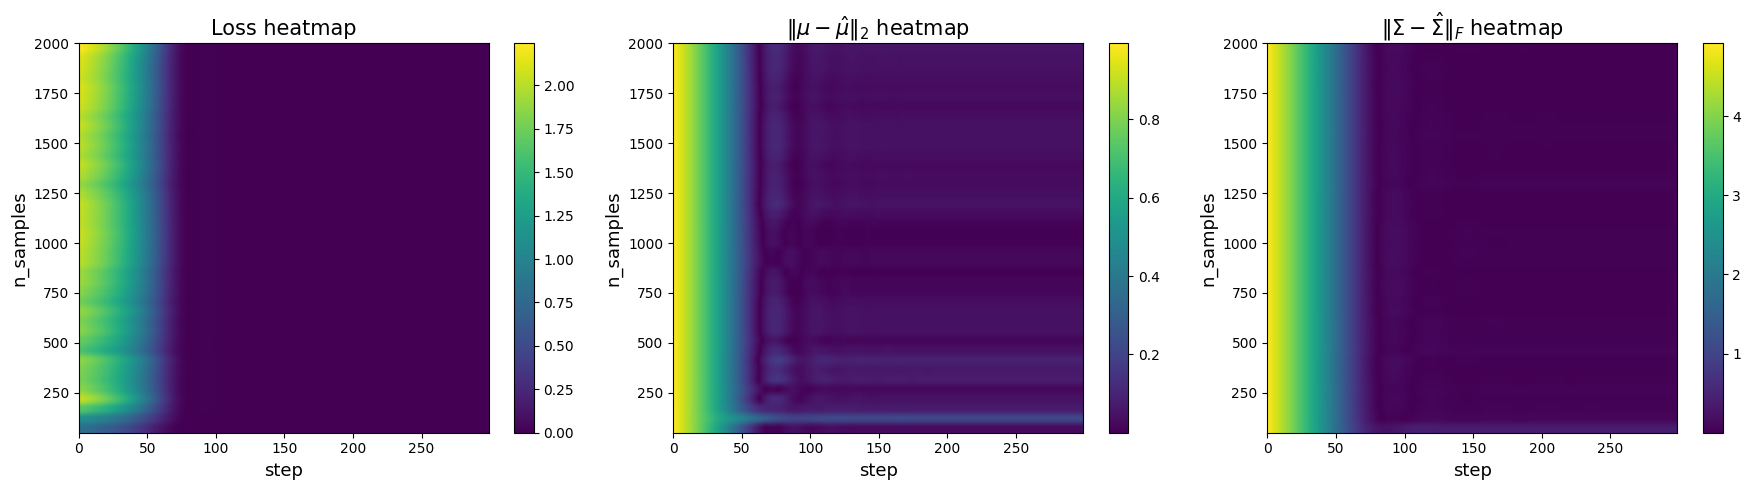

In [49]:
sample_sizes = np.arange(50, 2001, 50)
n_steps = 300

all_losses = []
all_mu_errors = []
all_cov_errors = []

for n in tqdm(sample_sizes):
    samples = generate_gaussian_samples(mu, cov, n, seed=0)
    _, _, history = lm_optimize_with_tracking(samples, mu, cov, n_epochs=300, base_lr=0.1, seed = 0)
    all_losses.append(np.array(history["loss"]))
    all_mu_errors.append(np.array(history["mu_l2"]))
    all_cov_errors.append(np.array(history["cov_fro"]))

# === plotting ===

import matplotlib.pyplot as plt

# Convertiamo i dati in array NumPy (se non già)
loss_matrix = np.array(all_losses)         # shape: (n_sample_sizes, n_steps)
mu_err_matrix = np.array(all_mu_errors)    # shape: (n_sample_sizes, n_steps)
cov_err_matrix = np.array(all_cov_errors)  # shape: (n_sample_sizes, n_steps)

# Assi
steps = np.arange(n_steps)
sample_sizes = np.arange(50, 2001, 50)

# Funzione per un singolo heatmap
def plot_heatmap(data, title, ylabel, cmap="viridis", vmin=None, vmax=None):
    plt.imshow(data, aspect="auto", origin="lower", cmap=cmap,
               extent=[steps[0], steps[-1], sample_sizes[0], sample_sizes[-1]],
               vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.xlabel("step", fontsize=13)
    plt.ylabel("n_samples", fontsize=13)
    plt.title(title, fontsize=15)

# Plot multiplo
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plot_heatmap(loss_matrix, "Loss heatmap", "n_samples")

plt.subplot(1, 3, 2)
plot_heatmap(mu_err_matrix, r"$\|\mu - \hat{\mu}\|_2$ heatmap", "n_samples")

plt.subplot(1, 3, 3)
plot_heatmap(cov_err_matrix, r"$\|\Sigma - \hat{\Sigma}\|_F$ heatmap", "n_samples")

plt.tight_layout()
plt.show()

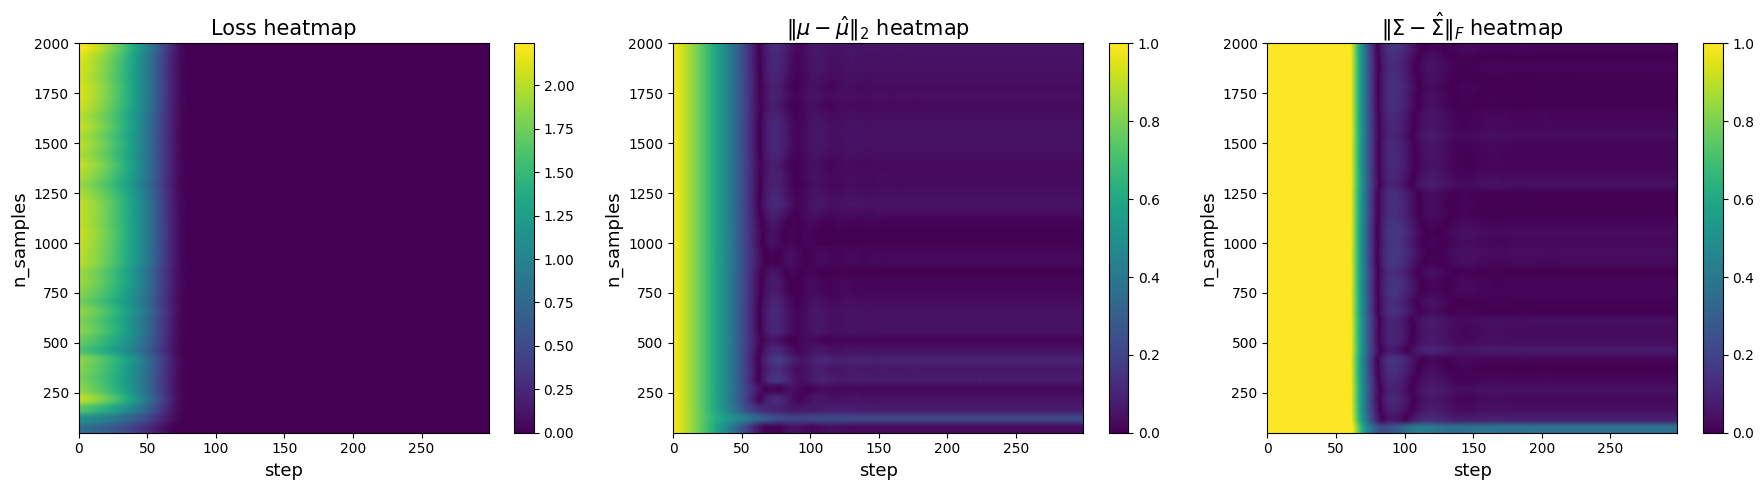

In [50]:
# Convertiamo i dati in array NumPy (se non già)
loss_matrix = np.array(all_losses)         # shape: (n_sample_sizes, n_steps)
mu_err_matrix = np.array(all_mu_errors)    # shape: (n_sample_sizes, n_steps)
cov_err_matrix = np.array(all_cov_errors)  # shape: (n_sample_sizes, n_steps)

# Assi
steps = np.arange(n_steps)
sample_sizes = np.arange(50, 2001, 50)

# Funzione per un singolo heatmap
def plot_heatmap(data, title, ylabel, cmap="viridis", vmin=None, vmax=None):
    plt.imshow(data, aspect="auto", origin="lower", cmap=cmap,
               extent=[steps[0], steps[-1], sample_sizes[0], sample_sizes[-1]],
               vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.xlabel("step", fontsize=13)
    plt.ylabel("n_samples", fontsize=13)
    plt.title(title, fontsize=15)

# Plot multiplo
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plot_heatmap(loss_matrix, "Loss heatmap", "n_samples")

plt.subplot(1, 3, 2)
plot_heatmap(mu_err_matrix, r"$\|\mu - \hat{\mu}\|_2$ heatmap", "n_samples", vmin = 0.0, vmax = 1.0)

plt.subplot(1, 3, 3)
plot_heatmap(cov_err_matrix, r"$\|\Sigma - \hat{\Sigma}\|_F$ heatmap", "n_samples", vmin = 0.0, vmax = 1.0)

plt.tight_layout()
plt.show()